# Capstone Project - The Battle of the Neighborhoods 
### Title : EXPLORING FOOD TYPES AROUND TRAIN STATIONS  IN WEST ZONE - RIO DE JANEIRO 
#### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

The propose of this project is research what are the most common types of restaurants around three train stations on the west zone of Rio de Janeiro (Bangu, Campo Grande and Santa Cruz). These train stations are located in very populous neighborhoods, near to their commercial area with: boardwalks, business centers, shopping malls and schools.  These train stations are integrate with bus lines and BRT Terminal (Campo Grande and Santa Cruz) making these areas have a large flow of people not only inside the stations, but also in their surroundings. With this, it is expected to draw food consumption profile of each analyzed group.

## 2. Data Selection <a name="data"></a>

To examine the proposed research, the following data sources will be used:

*Link*: https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_%C3%8Dndice_de_Desenvolvimento_Social

**Description**: We will use this ifnromation to web scraping the page and extract a table with three neighborhoods where I will apply the research.

**Foursquare API Data:**

In project we will need data about different venues in different neighborhoods. In order to obtain all this information we will use "Foursquare" locational information. 

Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we connect to the Foursquare API to get the information about venues around each train station. For each train station, we have chosen the radius to be 500 meter.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

          'categories': [{'id': '4bf58dd8d48988d16f941735',
          'name': 'Hot Dog Joint',
          'pluralName': 'Hot Dog Joints',
          'shortName': 'Hot Dogs',
          'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/hotdog_',
          'suffix': '.png'},
          'primary': True}],
          'referralId': 'v-1619115069',
          'hasPerk': False},

 ## 3. Download and Explore Dataset

*First let's import required libraries*

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans # import k-means from clustering stage


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import warnings
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


To get the table with the neighborhoods from wikipedia, we will use the BeautifulSoup as following:

In [2]:
html_data = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_do_Rio_de_Janeiro_por_%C3%8Dndice_de_Desenvolvimento_Social').content

In [3]:
soup = BeautifulSoup(html_data,'html.parser')

In [4]:
rio_table = soup.find_all(name ='table')

In [5]:
table_str = str(rio_table)
df_rio_bairro = pd.read_html(table_str)[0]
df_rio_bairro.head()

,Nº,Bairro,R.A,Região,IDS
0,1,Lagoa,Lagoa,Zona Sul,0.854
1,2,Leblon,Lagoa,Zona Sul,809.000
2,3,Ipanema,Lagoa,Zona Sul,801.000
3,4,Humaitá,Botafogo,Zona Sul,798.000
4,5,Urca,Botafogo,Zona Sul,795.000


In [6]:
df_rio_bairro.drop(['Nº','R.A','IDS'], axis=1, inplace=True) # Drop the columns that will not be necessary
df_rio_bairro.sort_values(by=['Região'], ascending=True)
df_rio_bairro.head()

,Bairro,Região
0,Lagoa,Zona Sul
1,Leblon,Zona Sul
2,Ipanema,Zona Sul
3,Humaitá,Zona Sul
4,Urca,Zona Sul


Let's apply a filter get only the neighborhoods where are the train stations that will be analysis.

In [7]:
df_zona_oeste = df_rio_bairro[(df_rio_bairro['Bairro'] == 'Campo Grande') | 
                              (df_rio_bairro['Bairro'] == 'Santa Cruz') | 
                              (df_rio_bairro['Bairro'] == 'Bangu')].reset_index(drop=True)
df_zona_oeste

,Bairro,Região
0,Bangu,Zona Oeste
1,Campo Grande,Zona Oeste
2,Santa Cruz,Zona Oeste


#### Now let's use geopy library to get the latitude and longitude  of neighborhoods to get the geographical coordinates

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent rj_explorer, as shown below.

In [8]:
# add Latituge e Longitude to dataframe
Latitude = []
Longitude = [] 

for i in df_zona_oeste['Bairro']:
    address = '{}, RJ'.format(i)
    geolocator = Nominatim(user_agent="rj_explorer")
    location = geolocator.geocode(address+ ',RJ')
    latitude = location.latitude
    longitude = location.longitude
    Latitude.append(latitude)
    Longitude.append(longitude)

df_zona_oeste['Latitude'] = Latitude
df_zona_oeste['Longitude'] = Longitude     
df_zona_oeste  

,Bairro,Região,Latitude,Longitude
0,Bangu,Zona Oeste,-22.875305,-43.464880
1,Campo Grande,Zona Oeste,-22.902953,-43.559129
2,Santa Cruz,Zona Oeste,-22.917625,-43.683491


Let's visualize these three neighborhoods in a map.

In [9]:
zona_oest_map = folium.Map(location=[-22.875305, -43.464880], zoom_start=12)

for lat, lng, Bairro, Região in zip(df_zona_oeste['Latitude'], df_zona_oeste['Longitude'], df_zona_oeste['Bairro'],df_zona_oeste['Região']):
    label = '{}, {}'.format(Bairro, Região)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(zona_oest_map) 

zona_oest_map

### 3.1 Foursquare API

The Foursquare Places API offers real-time access to Foursquare’s global database of rich venue data and user content to power your location-based experiences in your app or website


The API requires credentails as follows:

In [10]:

CLIENT_ID = 'FFJ0LKVRJ4EVUEACFEWW51AA2NPWBJPWBGK2CHNT0SIQYUSO' # your Foursquare ID
CLIENT_SECRET = 'U5CLZBAKILGF5JEMG2EDZGNN2EC5PZOTCCQ50PKC34CFKH2F' # your Foursquare Secret
ACCESS_TOKEN = 'KSLEBJNGP4CVKSSPM5HNQ5CE4OC5RTCMO53NGOT3SIGU2VX0' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30 # VERIFICAR
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: FFJ0LKVRJ4EVUEACFEWW51AA2NPWBJPWBGK2CHNT0SIQYUSO
CLIENT_SECRET:U5CLZBAKILGF5JEMG2EDZGNN2EC5PZOTCCQ50PKC34CFKH2F


From Foursquare API documentation, we can find the corresponding food category in Venue Categories. The corresponding ID of Food in Foursquare API is **4d4b7105d754a06374d81259** which is the main category. It contains several sub-categories that are related to food places such as : Brazilian Restaurant, Mexican  Restaurant, Fast Food Restaurant, among others.

As we want to find only places related to food around the train stations, we will use the CategoryID : **4d4b7105d754a06374d81259** to limit our research  this category.

First I will get the information from the venues around the Bangu train station and then I will apply these steps to get the Campo Grande and Santa Cruz train stations informations

### 3.2 Getting data for Bangu train Station

In [11]:
latitude_bg = df_zona_oeste['Latitude'][0] #To access the latitude in the dataframe.
longitude_bg = df_zona_oeste['Longitude'][0] #To access the longitude in the dataframe.
radius = 500 # Limit results to venues within this many meters of the specified location. 
LIMIT = 500 # Number of results to return.
CategoryID = '4d4b7105d754a06374d81259'# comma separated list of categories to limit results to. 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    latitude_bg,
    longitude_bg,
    ACCESS_TOKEN, 
    VERSION,    
    radius, 
    LIMIT,
    CategoryID)
url

'https://api.foursquare.com/v2/venues/search?client_id=FFJ0LKVRJ4EVUEACFEWW51AA2NPWBJPWBGK2CHNT0SIQYUSO&client_secret=U5CLZBAKILGF5JEMG2EDZGNN2EC5PZOTCCQ50PKC34CFKH2F&ll=-22.8753053,-43.4648805&oauth_token=KSLEBJNGP4CVKSSPM5HNQ5CE4OC5RTCMO53NGOT3SIGU2VX0&v=20180604&radius=500&limit=500&categoryId=4d4b7105d754a06374d81259'

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6084b4ae3864330f4b57148e'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 40}}],
 'response': {'venues': [{'id': '4bef3ae7c80dc92826b227e3',
    'name': 'Miguel Hot Dog',
    'location': {'address': 'Av. Sta. Cruz',
     'crossStreet': 'Em frente à estação de Bangu',
     'lat': -22.875542988532,
     'lng': -43.46516909262725,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.875542988532,
       'lng': -43.46516909262725}],
     'distance': 39,
     'cc': 'BR',
     'city': 'Rio de Janeiro',
     'state': 'RJ',
     'country': 'Brasil',
     'formattedAddress': ['Av. Sta. Cruz (Em frente à estação de Bangu)',
      'Rio de Janeiro, RJ']},
    'categories': [{'id': '4bf58dd8d48988d16f941735',
      'name': 'Hot Dog Joint',
      'pluralName': 'Hot Dog Joints',
      'shortName': 'Hot Dogs',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/hotdog_',
       'suffix': '.png'},
      'primary'

In [13]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df_bangu = pd.json_normalize(venues)
df_bangu.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode
0,4bef3ae7c80dc92826b227e3,Miguel Hot Dog,"[{'id': '4bf58dd8d48988d16f941735', 'name': 'H...",v-1619309742,False,Av. Sta. Cruz,Em frente à estação de Bangu,-22.875543,-43.465169,"[{'label': 'display', 'lat': -22.875542988532,...",39,BR,Rio de Janeiro,RJ,Brasil,"[Av. Sta. Cruz (Em frente à estação de Bangu),...",NaN
1,4eb71a6661af0dda91143d89,Estação Bangu Grill,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1619309742,False,"R. Cel. Tamarindo, 1894",NaN,-22.874863,-43.465432,"[{'label': 'display', 'lat': -22.8748627961542...",75,BR,Rio de Janeiro,RJ,Brasil,"[R. Cel. Tamarindo, 1894, Rio de Janeiro, RJ, ...",21840-447
2,59a8164f59fe5c0af1064f9c,McDonald's,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1619309742,False,Rua Barão de Capanema,Calçadão de Bangu,-22.879123,-43.467241,"[{'label': 'display', 'lat': -22.879123, 'lng'...",489,BR,Rio de Janeiro,RJ,Brasil,"[Rua Barão de Capanema (Calçadão de Bangu), Ri...",21820-080
3,50f30ccbe4b036c5d264a1fd,Quiosque Do Marco Geléia,"[{'id': '4bf58dd8d48988d1cb941735', 'name': 'F...",v-1619309742,False,Praça Dr Raymundo Paz,NaN,-22.879710,-43.465926,"[{'label': 'display', 'lat': -22.8797100914490...",501,BR,Rio de Janeiro,RJ,Brasil,"[Praça Dr Raymundo Paz, Rio de Janeiro, RJ]",NaN
4,5fa87dc58b9b6672c73cafe3,Oliva Culinária Caseira,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1619309742,False,Bangu shopping,NaN,-22.877613,-43.467285,"[{'label': 'display', 'lat': -22.877613, 'lng'...",356,BR,NaN,Rio de Janeiro,Brasil,"[Bangu shopping, Rio de Janeiro, 21820-005]",21820-005


In [14]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_bangu.columns if col.startswith('location.')] + ['id']
dataframe_filtered_bg = df_bangu.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_bg['categories'] = dataframe_filtered_bg.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_bg.columns = [column.split('.')[-1] for column in dataframe_filtered_bg.columns]

dataframe_filtered_bg.head(2)

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,id
0,Miguel Hot Dog,Hot Dog Joint,Av. Sta. Cruz,Em frente à estação de Bangu,-22.875543,-43.465169,"[{'label': 'display', 'lat': -22.875542988532,...",39,BR,Rio de Janeiro,RJ,Brasil,"[Av. Sta. Cruz (Em frente à estação de Bangu),...",NaN,4bef3ae7c80dc92826b227e3
1,Estação Bangu Grill,Pizza Place,"R. Cel. Tamarindo, 1894",NaN,-22.874863,-43.465432,"[{'label': 'display', 'lat': -22.8748627961542...",75,BR,Rio de Janeiro,RJ,Brasil,"[R. Cel. Tamarindo, 1894, Rio de Janeiro, RJ, ...",21840-447,4eb71a6661af0dda91143d89


In [15]:
df_bg_venues = dataframe_filtered_bg[['id','name','categories','lat','lng','distance']] #Lets appy a filter to get only this columns
df_bg_venues['Bairro'] = "Bangu" #let's create a column with the neighborhood
df_bg_venues.tail(2)

,id,name,categories,lat,lng,distance,Bairro
44,4f24680ee4b03bdcfcd2c452,Pizzaria e Choperia Santa Cecília,Pizza Place,-22.881035,-43.462310,690,Bangu
45,5671cab2498ea992ff4f84ae,Resenha Bar & Grill,Bar,-22.878174,-43.467165,396,Bangu


In [16]:
print('{} venues were returned by Foursquare.'.format(df_bg_venues.shape[0]))

46 venues were returned by Foursquare.


### 3.3 Getting data for Campo Grande train Station

In [17]:
latitude_cg = df_zona_oeste['Latitude'][1]#To access the latitude in the dataframe.
longitude_cg = df_zona_oeste['Longitude'][1]#To access the longitude in the dataframe.
radius = 500 # Limit results to venues within this many meters of the specified location.
LIMIT = 500 # Number of results to return.
CategoryID = '4d4b7105d754a06374d81259' # comma separated list of categories to limit results to. 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    latitude_cg,
    longitude_cg,
    ACCESS_TOKEN, 
    VERSION,    
    radius, 
    LIMIT,
    CategoryID)
url

'https://api.foursquare.com/v2/venues/search?client_id=FFJ0LKVRJ4EVUEACFEWW51AA2NPWBJPWBGK2CHNT0SIQYUSO&client_secret=U5CLZBAKILGF5JEMG2EDZGNN2EC5PZOTCCQ50PKC34CFKH2F&ll=-22.902953,-43.5591295&oauth_token=KSLEBJNGP4CVKSSPM5HNQ5CE4OC5RTCMO53NGOT3SIGU2VX0&v=20180604&radius=500&limit=500&categoryId=4d4b7105d754a06374d81259'

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6084b4afc6bf3339c2333a10'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 40}}],
 'response': {'venues': [{'id': '4c2e4cf8ed37a5937b556503',
    'name': "McDonald's",
    'location': {'address': 'R. Cel. Agostinho',
     'lat': -22.905316425779993,
     'lng': -43.55967817022056,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.905316425779993,
       'lng': -43.55967817022056}],
     'distance': 269,
     'postalCode': '23050-350',
     'cc': 'BR',
     'city': 'Rio de Janeiro',
     'state': 'RJ',
     'country': 'Brasil',
     'formattedAddress': ['R. Cel. Agostinho',
      'Rio de Janeiro, RJ',
      '23050-350']},
    'categories': [{'id': '4bf58dd8d48988d16e941735',
      'name': 'Fast Food Restaurant',
      'pluralName': 'Fast Food Restaurants',
      'shortName': 'Fast Food',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
       'suffix': '.png'},
      'primary': Tr

In [19]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df_cg = pd.json_normalize(venues)
df_cg.head(2)

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,4c2e4cf8ed37a5937b556503,McDonald's,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",v-1619309743,False,R. Cel. Agostinho,-22.905316,-43.559678,"[{'label': 'display', 'lat': -22.9053164257799...",269,23050-350,BR,Rio de Janeiro,RJ,Brasil,"[R. Cel. Agostinho, Rio de Janeiro, RJ, 23050-...",NaN,NaN
1,4d3065404db137046e01fb5d,Bis,"[{'id': '4bf58dd8d48988d16b941735', 'name': 'B...",v-1619309743,False,"R. Augusto de Vasconcelos, 11",-22.902869,-43.559813,"[{'label': 'display', 'lat': -22.9028689707793...",70,23050-340,BR,Rio de Janeiro,RJ,Brasil,"[R. Augusto de Vasconcelos, 11, Rio de Janeiro...",NaN,NaN


In [20]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_cg.columns if col.startswith('location.')] + ['id']
dataframe_filtered_cg = df_cg.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_cg['categories'] = dataframe_filtered_cg.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_cg.columns = [column.split('.')[-1] for column in dataframe_filtered_cg.columns]

dataframe_filtered_cg.head(2)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,McDonald's,Fast Food Restaurant,R. Cel. Agostinho,-22.905316,-43.559678,"[{'label': 'display', 'lat': -22.9053164257799...",269,23050-350,BR,Rio de Janeiro,RJ,Brasil,"[R. Cel. Agostinho, Rio de Janeiro, RJ, 23050-...",NaN,NaN,4c2e4cf8ed37a5937b556503
1,Bis,Brazilian Restaurant,"R. Augusto de Vasconcelos, 11",-22.902869,-43.559813,"[{'label': 'display', 'lat': -22.9028689707793...",70,23050-340,BR,Rio de Janeiro,RJ,Brasil,"[R. Augusto de Vasconcelos, 11, Rio de Janeiro...",NaN,NaN,4d3065404db137046e01fb5d


In [21]:
#Lets appy a filter to get only this columns
df_cg_venues = dataframe_filtered_cg[['id','name','categories','lat','lng','distance']]

df_cg_venues['Bairro'] = "Campo Grande" #let's create a column with the neighborhood
df_cg_venues.tail(2)

,id,name,categories,lat,lng,distance,Bairro
45,53602599498ea72b54c9f958,Cachorro Quente da Tia,Hot Dog Joint,-22.900147,-43.554835,539,Campo Grande
46,50b62a2ce4b04756f653276f,"Self Service 7,99 Sem Balanca",Brazilian Restaurant,-22.900647,-43.561131,328,Campo Grande


In [22]:
print('{} venues were returned by Foursquare.'.format(df_cg_venues.shape[0]))

47 venues were returned by Foursquare.


### 3.4 Getting data for Santa Cruz  train Station

In [23]:
latitude_st = df_zona_oeste['Latitude'][2]#To access the latitude in the dataframe.
longitude_st = df_zona_oeste['Longitude'][2]#To access the longitude in the dataframe.
radius = 500 #Limit results to venues within this many meters of the specified location.
LIMIT = 500 #Number of results to return.
CategoryID = '4d4b7105d754a06374d81259' # comma separated list of categories to limit results to. 
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    latitude_st,
    longitude_st,
    ACCESS_TOKEN, 
    VERSION,    
    radius, 
    LIMIT,
    CategoryID)
url

'https://api.foursquare.com/v2/venues/search?client_id=FFJ0LKVRJ4EVUEACFEWW51AA2NPWBJPWBGK2CHNT0SIQYUSO&client_secret=U5CLZBAKILGF5JEMG2EDZGNN2EC5PZOTCCQ50PKC34CFKH2F&ll=-22.9176248,-43.6834907&oauth_token=KSLEBJNGP4CVKSSPM5HNQ5CE4OC5RTCMO53NGOT3SIGU2VX0&v=20180604&radius=500&limit=500&categoryId=4d4b7105d754a06374d81259'

In [24]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6084b4b1c7898674fec06d64'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 40}}],
 'response': {'venues': [{'id': '4f5f67d9e4b0b79c826f89c4',
    'name': 'Restaurante N & R',
    'location': {'lat': -22.917911440323348,
     'lng': -43.684260244548106,
     'labeledLatLngs': [{'label': 'display',
       'lat': -22.917911440323348,
       'lng': -43.684260244548106}],
     'distance': 85,
     'cc': 'BR',
     'city': 'Rio de Janeiro',
     'state': 'RJ',
     'country': 'Brasil',
     'formattedAddress': ['Rio de Janeiro, RJ']},
    'categories': [{'id': '4bf58dd8d48988d1c4941735',
      'name': 'Restaurant',
      'pluralName': 'Restaurants',
      'shortName': 'Restaurant',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1619309745',
    'hasPerk': False},
   {'id': '4c9e8ba52fb1a14392bfeb40',
    'name': 'Fornetto Pizz

In [25]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
df_st = pd.json_normalize(venues)
df_st.head(2)

,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.address,location.postalCode,location.crossStreet
0,4f5f67d9e4b0b79c826f89c4,Restaurante N & R,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1619309745,False,-22.917911,-43.684260,"[{'label': 'display', 'lat': -22.9179114403233...",85,BR,Rio de Janeiro,RJ,Brasil,"[Rio de Janeiro, RJ]",NaN,NaN,NaN
1,4c9e8ba52fb1a14392bfeb40,Fornetto Pizzaria e Restaurante,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1619309745,False,-22.917419,-43.682485,"[{'label': 'display', 'lat': -22.9174192991497...",105,BR,Rio de Janeiro,RJ,Brasil,"[R. Vde. de Sepetiba, 83, Rio de Janeiro, RJ, ...","R. Vde. de Sepetiba, 83",23510-130,NaN


In [26]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_st.columns if col.startswith('location.')] + ['id']
dataframe_filtered_st = df_st.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_st['categories'] = dataframe_filtered_st.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_st.columns = [column.split('.')[-1] for column in dataframe_filtered_st.columns]

dataframe_filtered_st.head(2)

,name,categories,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,address,postalCode,crossStreet,id
0,Restaurante N & R,Restaurant,-22.917911,-43.684260,"[{'label': 'display', 'lat': -22.9179114403233...",85,BR,Rio de Janeiro,RJ,Brasil,"[Rio de Janeiro, RJ]",NaN,NaN,NaN,4f5f67d9e4b0b79c826f89c4
1,Fornetto Pizzaria e Restaurante,Pizza Place,-22.917419,-43.682485,"[{'label': 'display', 'lat': -22.9174192991497...",105,BR,Rio de Janeiro,RJ,Brasil,"[R. Vde. de Sepetiba, 83, Rio de Janeiro, RJ, ...","R. Vde. de Sepetiba, 83",23510-130,NaN,4c9e8ba52fb1a14392bfeb40


In [27]:
#Lets appy a filter to get only this columns
df_st_venues = dataframe_filtered_st[['id','name','categories','lat','lng','distance']]
df_st_venues['Bairro'] = "Santa Cruz"
df_st_venues.tail(2)

,id,name,categories,lat,lng,distance,Bairro
48,50992ef9498e20f69f77406f,Sônia's lanches,Brazilian Restaurant,-22.919576,-43.678511,554,Santa Cruz
49,4f3d1e9ee4b0a92482b7c0d7,pastelaria dragao de ouro,Chinese Restaurant,-22.918812,-43.680954,291,Santa Cruz


In [28]:
print('{} venues were returned by Foursquare.'.format(df_st_venues.shape[0]))

50 venues were returned by Foursquare.


**Now that we have all three dataframes created, let's concatenate all of them.**

In [29]:
df_venues_zo = pd.concat([df_bg_venues, df_cg_venues,df_st_venues]).reset_index(drop=True)
df_venues_zo.tail(4)

,id,name,categories,lat,lng,distance,Bairro
139,5740c470498e6896a498fae9,Pimenta Maluca,Pie Shop,-22.920914,-43.681620,413,Santa Cruz
140,5491f04c498e40fd4db61dad,Moderninho,Snack Place,-22.918707,-43.680710,309,Santa Cruz
141,50992ef9498e20f69f77406f,Sônia's lanches,Brazilian Restaurant,-22.919576,-43.678511,554,Santa Cruz
142,4f3d1e9ee4b0a92482b7c0d7,pastelaria dragao de ouro,Chinese Restaurant,-22.918812,-43.680954,291,Santa Cruz


**_Let's visualize all train stations and the venues in the map._**

In [30]:
venues_map = folium.Map(location=[latitude_cg, longitude_cg], zoom_start=13) # crate a map that represent the strain stations

# add a red  marker to represent the strain stations
for lat, lon, bairro in zip(df_zona_oeste['Latitude'],df_zona_oeste['Longitude'],df_zona_oeste['Bairro']):
    folium.Marker([lat, lon],
    popup=bairro,
    icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(venues_map)

# add the venues as blue circle markers
for lat, lng, label in zip(df_venues_zo.lat, df_venues_zo.lng, df_venues_zo.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

## 4. Cluster Neighborhoods <a name="methodology"></a>

__The Elbow Method__ : _Is used in determining the number of clusters in a dataset. This method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use._

__The Silhouette Method__ : _The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters._

**K-means**: _Clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster._

                                                                                                        Source: Wikipedia

For clustering, K-means method will be applied. To be able to select the optimal number of clusters, the silhouette score will be used.

First, let's find out the optimal number of clusters. For that, we will create a graph of Elbow Method, silhouette and the silhouette scores for each train station.

In [31]:
df1= df_bg_venues[['lat','lng']] #data frame with Bangu  geografic information.
df2= df_cg_venues[['lat','lng']] #data frame with Campo Grande  geografic information.
df3= df_st_venues[['lat','lng']] #data frame with Santa Cruz  geografic information.

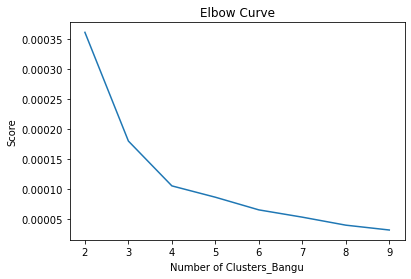

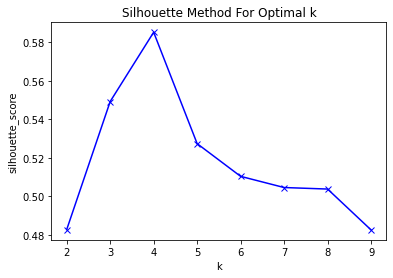

N_cluster: 2, score: 0.48281474825934906
N_cluster: 3, score: 0.5493154591108179
N_cluster: 4, score: 0.5852903506831614
N_cluster: 5, score: 0.5274491152508441
N_cluster: 6, score: 0.5282275450406949
N_cluster: 7, score: 0.4796643580769349
N_cluster: 8, score: 0.4928442001311325


In [63]:
#Elbow Method
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df1[['lat']]
X_axis = df1[['lng']]
score = [kmeans[i].fit(df1).inertia_ for i in range(len(kmeans))]

# Visualization
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters_Bangu')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

#Silhouette Method 
sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df1)
    labels = kmeans.labels_
    sil.append(silhouette_score(df1, labels, metric = 'euclidean')) 
    
#Visualization
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

#Silhouette_score
for i in range(2,9):
  kmeans_ = KMeans(n_clusters=i).fit(df1)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df1,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

As we can see above the best cluster number to use is the number 4. So now let's put this information into Bangu train station dataframe and repet the same process and analysys to Campo Grande and Santa Cruz stations.

In [50]:
X= np.array(df1)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
kmeans.labels_
df_bg_venues['clusterlabels'] = kmeans.labels_

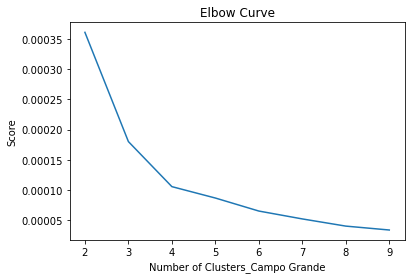

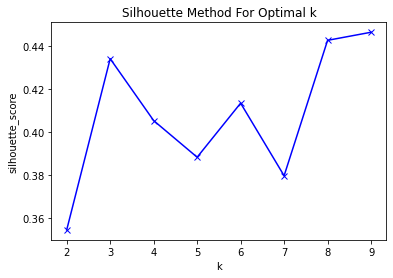

N_cluster: 2, score: 0.354372297916514
N_cluster: 3, score: 0.4341741063757699
N_cluster: 4, score: 0.4053263447872574
N_cluster: 5, score: 0.40587889851770104
N_cluster: 6, score: 0.3881333826237742
N_cluster: 7, score: 0.4185379138699125
N_cluster: 8, score: 0.4335397818596091


In [51]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df2[['lat']]
X_axis = df2[['lng']]
score = [kmeans[i].fit(df1).inertia_ for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters_Campo Grande')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df2)
    labels = kmeans.labels_
    sil.append(silhouette_score(df2, labels, metric = 'euclidean')) 
#Visualization
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()


for i in range(2,9):
  kmeans_ = KMeans(n_clusters=i).fit(df2)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df2,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In this case the score indicates to use 3 or 8 clusters, but in this analysis I've decided to use 4 as well.

In [64]:
Y= np.array(df2)
kmeans = KMeans(n_clusters=4, random_state=0).fit(Y)
kmeans.labels_
df_cg_venues['clusterlabels'] = kmeans.labels_

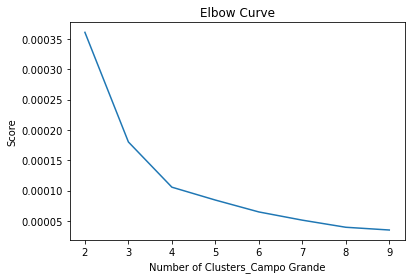

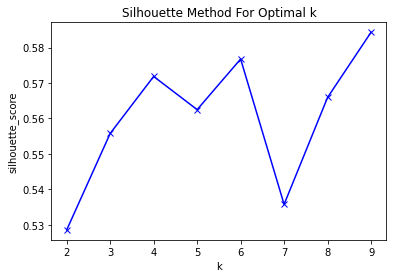

N_cluster: 2, score: 0.5471139395550297
N_cluster: 3, score: 0.5557840434939509
N_cluster: 4, score: 0.5718630478841784
N_cluster: 5, score: 0.5625001171613185
N_cluster: 6, score: 0.5698758940502573
N_cluster: 7, score: 0.5469210721484008
N_cluster: 8, score: 0.5569905296831329


In [53]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df3[['lat']]
X_axis = df3[['lng']]
score = [kmeans[i].fit(df1).inertia_ for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters_Campo Grande')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df3)
    labels = kmeans.labels_
    sil.append(silhouette_score(df3, labels, metric = 'euclidean')) 
#Visualization
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()


for i in range(2,9):
  kmeans_ = KMeans(n_clusters=i).fit(df3)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df3,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In this case the score indicates to use 5 clusters, but in this analysis I've decided to use 4 as well. 

In [65]:
Z= np.array(df3)
kmeans = KMeans(n_clusters=4, random_state=0).fit(Z)
kmeans.labels_
df_st_venues['clusterlabels'] = kmeans.labels_

Now let's concatenate this tables and put it all in the _df_venues _zo_ dataframe and continue our analysis.

In [66]:
df_venues_zo = pd.concat([df_bg_venues, df_cg_venues,df_st_venues]).reset_index(drop=True) 
df_venues_zo.tail(5)

,id,name,categories,lat,lng,distance,Bairro,clusterlabels
138,527ee4e611d27152869afb1c,Dan Pizzas Express,Pizza Place,-22.922729,-43.682720,573,Santa Cruz,2
139,5740c470498e6896a498fae9,Pimenta Maluca,Pie Shop,-22.920914,-43.681620,413,Santa Cruz,2
140,5491f04c498e40fd4db61dad,Moderninho,Snack Place,-22.918707,-43.680710,309,Santa Cruz,1
141,50992ef9498e20f69f77406f,Sônia's lanches,Brazilian Restaurant,-22.919576,-43.678511,554,Santa Cruz,1
142,4f3d1e9ee4b0a92482b7c0d7,pastelaria dragao de ouro,Chinese Restaurant,-22.918812,-43.680954,291,Santa Cruz,1


Let's plot a map with the three train stations separated to clusters.

In [67]:
cluster_map = folium.Map(location=[latitude_cg, longitude_cg], zoom_start=12) # crate a map that represent the strain stations
colors={0:'orange',1:'blue',2:'green',3:'purple',4:'yellow'}

# add a red marker to represent the train stations 
for lat, lon, bairro in zip(df_zona_oeste['Latitude'],df_zona_oeste['Longitude'],df_zona_oeste['Bairro']):
    folium.Marker([lat, lon],
    popup=bairro,
    icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(cluster_map)

# add the venues as circle markers by clusters
for lat, lon, clusters, name in zip(df_venues_zo['lat'],df_venues_zo['lng'],
                                    df_venues_zo['clusterlabels'],df_venues_zo['categories']):
    label=folium.Popup(str(name) + ', Cluster: ' + str(clusters), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,
        popup=label,
        fill=True,
        color=colors[clusters],
        fill_color=colors[clusters],
        fill_opacity=0.6
        ).add_to(cluster_map)

#show the map
cluster_map

Let's use the on hot encoding to see how frequency the venus appear in each neighborhood

In [68]:
# one hot encoding
venues_onehot = pd.get_dummies(df_venues_zo[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Bairro'] = df_venues_zo['Bairro'] 

# move Bairro column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
venues_grouped = venues_onehot.groupby('Bairro').mean().reset_index()
venues_onehot.head(5)

,Bairro,American Restaurant,BBQ Joint,Bakery,Bar,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Cafeteria,Café,Central Brazilian Restaurant,Chinese Restaurant,Churrascaria,Coffee Shop,Comfort Food Restaurant,Deli / Bodega,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Truck,Fried Chicken Joint,Gastropub,Hot Dog Joint,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Juice Bar,Mineiro Restaurant,Pastelaria,Pie Shop,Pizza Place,Restaurant,Sandwich Place,Snack Place,South American Restaurant,Sushi Restaurant,Tapiocaria,Tea Room
0,Bangu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bangu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Bangu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bangu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bangu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [69]:
num_top_venues = 10  #
for hood in venues_grouped['Bairro']:
    print("---- "+hood+" ----")
    temp =venues_grouped[venues_grouped['Bairro'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Bangu ----
                  venue  freq
0            Restaurant  0.13
1           Pizza Place  0.13
2           Snack Place  0.11
3  Fast Food Restaurant  0.09
4             BBQ Joint  0.07
5           Coffee Shop  0.07
6            Food Truck  0.04
7    Mineiro Restaurant  0.04
8          Burger Joint  0.04
9                   Bar  0.04


---- Campo Grande ----
                  venue  freq
0  Brazilian Restaurant  0.19
1  Fast Food Restaurant  0.09
2        Breakfast Spot  0.06
3            Food Truck  0.06
4            Restaurant  0.06
5           Snack Place  0.06
6             Juice Bar  0.04
7                 Diner  0.04
8         Hot Dog Joint  0.04
9             BBQ Joint  0.04


---- Santa Cruz ----
                  venue  freq
0           Snack Place  0.20
1            Restaurant  0.16
2           Pizza Place  0.08
3  Brazilian Restaurant  0.08
4            Food Truck  0.06
5             BBQ Joint  0.06
6  Fast Food Restaurant  0.06
7                Bakery  0.04
8     


Let's write a function to sort the venues in descending order

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Bairro']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bairros_venues_sorted = pd.DataFrame(columns=columns)
bairros_venues_sorted['Bairro'] = venues_grouped['Bairro']

for ind in np.arange(venues_grouped.shape[0]):
    bairros_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

bairros_venues_sorted

,Bairro,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangu,Restaurant,Pizza Place,Snack Place,Fast Food Restaurant,BBQ Joint,Coffee Shop,Bar,Burger Joint,Mineiro Restaurant,Food Truck
1,Campo Grande,Brazilian Restaurant,Fast Food Restaurant,Snack Place,Restaurant,Food Truck,Breakfast Spot,Coffee Shop,BBQ Joint,Hot Dog Joint,Diner
2,Santa Cruz,Snack Place,Restaurant,Brazilian Restaurant,Pizza Place,BBQ Joint,Fast Food Restaurant,Food Truck,Bakery,Tea Room,Gastropub


## 5. Examine Clusters <a name="analysis"></a>   

Now we will analyze each station separately and check the types and quantities of restaurants we have around each one.

### 5.1 Bangu

In [72]:
cluster_0_bg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 0) & (df_venues_zo['Bairro'] == 'Bangu')] #select only one cluster in in Bangu 
cluster_0_bg = cluster_0_bg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1) #drop columns 
cluster_0_bg = cluster_0_bg.sort_values(by='clusterlabels', ascending = True) #order by cluster labels 
cluster_0_bg = cluster_0_bg.tail(5)

cluster_1_bg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 1) & (df_venues_zo['Bairro'] == 'Bangu')]
cluster_1_bg = cluster_1_bg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_1_bg = cluster_1_bg.sort_values(by='clusterlabels', ascending = True)
cluster_1_bg = cluster_1_bg.tail(5)

cluster_2_bg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 2) & (df_venues_zo['Bairro'] == 'Bangu')]
cluster_2_bg = cluster_2_bg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_2_bg = cluster_2_bg.sort_values(by='clusterlabels', ascending = True)
cluster_2_bg = cluster_2_bg.tail(5)

cluster_3_bg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 3) & (df_venues_zo['Bairro'] == 'Bangu')]
cluster_3_bg = cluster_3_bg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_3_bg = cluster_3_bg.sort_values(by='clusterlabels', ascending = True)
cluster_3_bg = cluster_3_bg.tail(5)

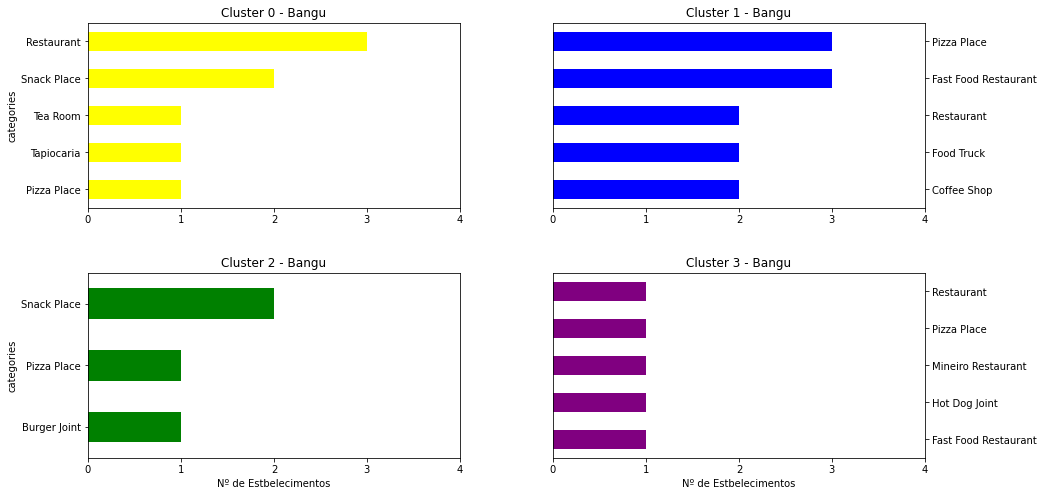

In [73]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)
ax2 = fig.add_subplot(2, 2, 3) # add subplot 2 (1 row, 2 columns, third plot)
ax3 = fig.add_subplot(2, 2, 4) # add subplot 2 (1 row, 2 columns, fourth plot)

#Visuzalization and ajusts 
cluster_0_bg.plot(kind='barh', figsize=(15, 8), color='yellow',ax=ax0) #set color, figure size, e chart type
ax0.set_title('Cluster 0 - Bangu') # add title to the plot
ax0.legend().remove()# remove the legend
ax0.set_xticks(np.arange(0, 5, step=1))

cluster_1_bg.plot(kind='barh', figsize=(15, 8), color='blue',ax=ax1) #set color, figure size, e chart type
ax1.set_title('Cluster 1 - Bangu') 
ax1.legend().remove()# remove the legend
ax1.set_ylabel(None)# remove y label
ax1.yaxis.tick_right() #put the y ticks in teh right side
ax1.set_xticks(np.arange(0, 5, step=1))

cluster_2_bg.plot(kind='barh', figsize=(15, 8), color='green',ax=ax2) #set color, figure size, e chart type
ax2.set_xlabel('Nº de Estbelecimentos')## add to x-label to the plot
ax2.set_title('Cluster 2 - Bangu') # add title to the plot
ax2.legend().remove()# remove the legend
ax2.set_xticks(np.arange(0, 5, step=1))

cluster_3_bg.plot(kind='barh', figsize=(15, 8), color='purple', ax=ax3) #set color, figure size, e chart type
ax3.set_xlabel('Nº de Estbelecimentos') # add to x-label to the plot
ax3.set_title('Cluster 3 - Bangu') # add title to the plot
ax3.legend().remove()# remove the legend
ax3.set_ylabel(None)# remove y label
ax3.yaxis.tick_right() #put the y ticks in teh right side
ax3.set_xticks(np.arange(0, 5, step=1)) #set the steps and range of the plot

plt.subplots_adjust(hspace=0.35,wspace=0.25) #set the space between the plots
plt.show() #show Plots

As we can see above, I selected only the 5 types of establishments in each cluster. 

The **Cluster 0** is where we have the highest concentration of restaurants. 

The **Cluster 1** has a wide variety of restaurants, but analyzing the data on the map, I verified that this all locations in cluster 02 are located inside Shopping Bangu, which is next to the train station. That's why it has more places.

The **Cluster 2** does not have any restaurants and only snack places.

In **Cluster 3** we can see that this cluster has less restaurants when compared to the others. 

### 5. 2 Campo Grande

In [74]:
cluster_0_cg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 0) & (df_venues_zo['Bairro'] == 'Campo Grande')]#select only one cluster in in Campo Grande
cluster_0_cg = cluster_0_cg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)#drop columns
cluster_0_cg = cluster_0_cg.sort_values(by='clusterlabels', ascending = True)
cluster_0_cg = cluster_0_cg.tail(5)

cluster_1_cg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 1) & (df_venues_zo['Bairro'] == 'Campo Grande')]
cluster_1_cg = cluster_1_cg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_1_cg = cluster_1_cg.sort_values(by='clusterlabels', ascending = True)
cluster_1_cg = cluster_1_cg.tail(5)

cluster_2_cg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 2) & (df_venues_zo['Bairro'] == 'Campo Grande')]
cluster_2_cg = cluster_2_cg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_2_cg = cluster_2_cg.sort_values(by='clusterlabels', ascending = True)
cluster_2_cg = cluster_2_cg.tail(5)

cluster_3_cg = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 3) & (df_venues_zo['Bairro'] == 'Campo Grande')]
cluster_3_cg = cluster_3_cg.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_3_cg = cluster_3_cg.sort_values(by='clusterlabels', ascending = True)
cluster_3_cg = cluster_3_cg.tail(5)

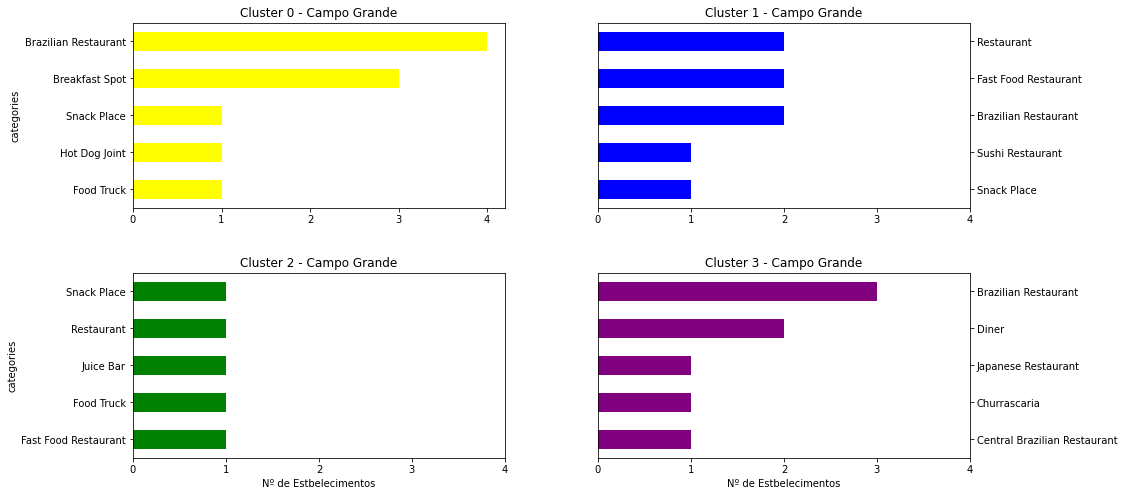

In [75]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)
ax2 = fig.add_subplot(2, 2, 3) # add subplot 2 (1 row, 2 columns, third plot)
ax3 = fig.add_subplot(2, 2, 4) # add subplot 2 (1 row, 2 columns, fourth plot)

#Visuzalization and ajusts 
cluster_0_cg.plot(kind='barh', figsize=(15, 8), color='yellow',ax=ax0) #set color, figure size, e chart type
ax0.set_title('Cluster 0 - Campo Grande') # add title to the plot
ax0.legend().remove()# remove the legend
ax0.set_xticks(np.arange(0, 5, step=1))#set the steps and range of the plot

cluster_1_cg.plot(kind='barh', figsize=(15, 8), color='blue',ax=ax1) 
ax1.set_title('Cluster 1 - Campo Grande') # add title to the plot
ax1.legend().remove()# remove the legend
ax1.set_ylabel(None)# remove y label
ax1.yaxis.tick_right()#put the y ticks in teh right side
ax1.set_xticks(np.arange(0, 5, step=1))

cluster_2_cg.plot(kind='barh', figsize=(15, 8), color='green',ax=ax2) 
ax2.set_xlabel('Nº de Estbelecimentos')# add to x-label to the plot
ax2.set_title('Cluster 2 - Campo Grande') # add title to the plot
ax2.legend().remove()# remove the legend
ax2.set_xticks(np.arange(0, 5, step=1))

cluster_3_cg.plot(kind='barh', figsize=(15, 8), color='purple', ax=ax3) 
ax3.set_xlabel('Nº de Estbelecimentos') # add to x-label to the plot
ax3.set_title('Cluster 3 - Campo Grande') # add title to the plot
ax3.legend().remove()# remove the legend
ax3.set_ylabel(None)# remove y label
ax3.yaxis.tick_right()#put the y ticks in teh right side
ax3.set_xticks(np.arange(0, 5, step=1))

plt.subplots_adjust(hspace=0.35,wspace=0.25) #set the space between the plots
plt.show()

As we can see above, I selected only the 5 types of establishments in each cluster.

In the **Cluster 0** we can see that this cluster has more restaurants when compared to the others and this cluster is the closest to the train station. 

in the **Cluster 1**  has more restaurants than snack places.

The **Cluster 2** has only one restaurant.

The **Cluster 3** only have  restaurants and there is no snack places.

### 5.3 Santa Cruz

In [76]:
cluster_0_st = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 0) & (df_venues_zo['Bairro'] == 'Santa Cruz')]#select only one cluster in in Santa Cruz
cluster_0_st = cluster_0_st.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)#drop columns
cluster_0_st = cluster_0_st.sort_values(by='clusterlabels', ascending = True)
cluster_0_st =cluster_0_st.tail(5)

cluster_1_st = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 1) & (df_venues_zo['Bairro'] == 'Santa Cruz')]
cluster_1_st = cluster_1_st.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_1_st = cluster_1_st.sort_values(by='clusterlabels', ascending = True)
cluster_1_st =cluster_1_st.tail(5)

cluster_2_st = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 2) & (df_venues_zo['Bairro'] == 'Santa Cruz')]
cluster_2_st = cluster_2_st.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_2_st = cluster_2_st.sort_values(by='clusterlabels', ascending = True)
cluster_2_st =cluster_2_st.tail(5)

cluster_3_st = df_venues_zo.loc[(df_venues_zo['clusterlabels'] == 3) & (df_venues_zo['Bairro'] == 'Santa Cruz')]
cluster_3_st = cluster_3_st.groupby('categories').count().drop(['id','lng','name','lat','distance','Bairro'], axis=1)
cluster_3_st = cluster_3_st.sort_values(by='clusterlabels', ascending = True)
cluster_3_st =cluster_3_st.tail(5)

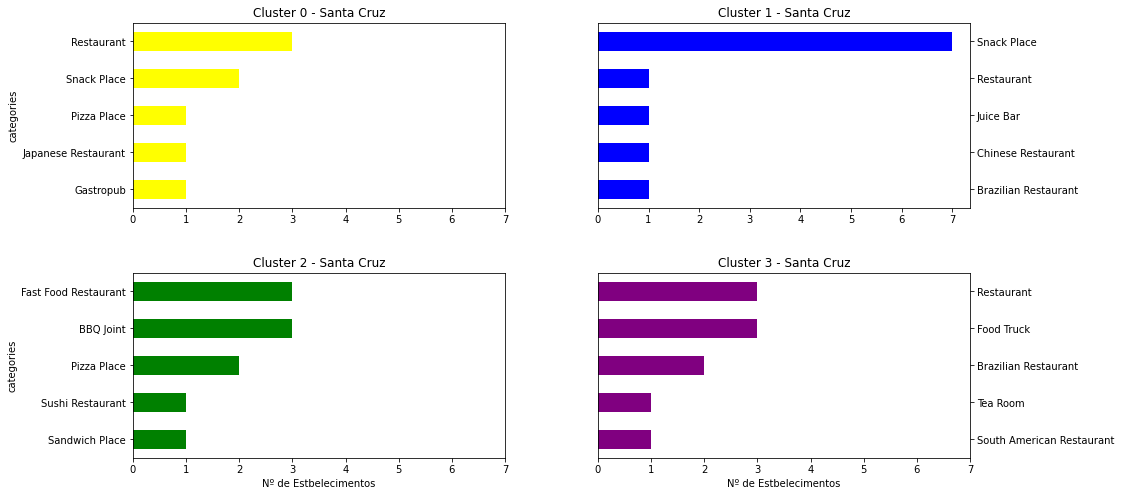

In [77]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)
ax2 = fig.add_subplot(2, 2, 3) # add subplot 2 (1 row, 2 columns, third plot)
ax3 = fig.add_subplot(2, 2, 4) # add subplot 2 (1 row, 2 columns, fourth plot)

#Visuzalization and ajusts 
cluster_0_st.plot(kind='barh', figsize=(15, 8), color='yellow',ax=ax0) #set color, figure size, e chart type
ax0.set_title('Cluster 0 - Santa Cruz') # add title to the plot
ax0.legend().remove()# remove the legend
ax0.set_xticks(np.arange(0, 8, step=1))#set the steps and range of the plot

cluster_1_st.plot(kind='barh', figsize=(15, 8), color='blue',ax=ax1)
ax1.set_title('Cluster 1 - Santa Cruz') 
ax1.legend().remove()
ax1.set_ylabel(None)# remove y label
ax1.yaxis.tick_right()#put the y ticks in teh right side
ax1.set_xticks(np.arange(0, 8, step=1)) #set the steps and range of the plot

cluster_2_st.plot(kind='barh', figsize=(15, 8), color='green',ax=ax2)
ax2.set_xlabel('Nº de Estbelecimentos')
ax2.set_title('Cluster 2 - Santa Cruz') # add title to the plot
ax2.legend().remove()
ax2.set_xticks(np.arange(0, 8, step=1))

cluster_3_st.plot(kind='barh', figsize=(15, 8), color='purple', ax=ax3)
ax3.set_xlabel('Nº de Estbelecimentos') # add to x-label to the plot
ax3.set_title('Cluster 3 - Santa Cruz') # add title to the plot
ax3.legend().remove()# remove the legend
ax3.set_ylabel(None)# remove y label
ax3.yaxis.tick_right()#put the y ticks in teh right side
ax3.set_xticks(np.arange(0, 8, step=1))#set the steps and range of the plot

plt.subplots_adjust(hspace=0.35,wspace=0.25)#set the space between the plots
plt.show()

As we can see above, I selected only the 5 types of establishments in each cluster.

in the **Cluster 0**  has the same quantity of restaurants and snack plances.

In the **Cluster 1** we can see that this cluster has more sneack place when compared to the others clusters. 

The **Cluster 2** has only one  sushi restaurant and more fast food places.

The **Cluster 3** is the cluster that have more restaurants and there is no snack places.

## 6. Results and Discussion <a name="results"></a>

The three regions analyzed are regions that have many unusual characteristics. The stations are close to the shopping centers in each neighborhood, terminals for integration with intercity bus lines, so I expected to find places that had similar characteristics. Bangu and Santa Cruz stations are stations located close to schools, shops and have a large number of people. The Campo Grande station, in addition to having all the previous similarities, still has a different characteristic, which is the presence of business buildings, making it have a slightly different audience than the other two regions.

Analyzing the clusters of the three stations, we find that snack bars appear more frequently in Santa Cruz and Bangu and in Campo Grande what we have most is the presence of restaurants in all cluters.

When analyzing the data from Bangu, I found that cluster 1 had a wide variety of restaurant type locations, and when analyzing the cluster on the map, I could see that this cluster belongs to Shopping Bangu, which makes sense because we have a lot of variety inside the food court. In addition pizzeria is common in the region.

In Campo Grande, what is most prevalent are the restaurants that appear in all clusters, clusters 0 and 1 have most of their restaurants.

Something very interesting that I noticed when analyzing the data from Santa Cruz, was that most of the snack places were inside cluster 1. The number of cafeterias was high in relation to all the other analyzed clusters of the three stations. Upon analyzing the location, I found that they are located close to colleges and schools. Cluster 2 are all owned by Shopping de Santa Cruz, which is also close to the station.

## 7. Conclusion <a name="conclusion"></a>

When comparing the three locations, we can see that the profile of restaurants is very similar to the regulars of lacais. Campo Grande for having more business buildings, has a larger number of restaurants in the region. Bangu and Santa Cruz, on the other hand, have a slightly different profile than Campo Grande, but are more similar to each other.

From this first analysis, it can be concluded that the public in Campo Grande has a greater variety of places with healthier foods and in Bangu and Santa Cruz have a greater number of snack bars.

The initial proposal of the project was to analyze these regions and verify what types of restaurants we have around the stations and from there, for another future project, correlate the analysis with the quality of food of the people who use them and transit around of the locations.